# Homework 2

## Import Libraries

Import some libraries

In [0]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


## Load data

In [0]:
import os
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
drive.mount('/content/drive')

trainingset = '/content/drive/My Drive/MWI-Dataset1/MWI-Dataset1'
testset='/content/drive/My Drive/Weather_Dataset'

batch_size = 64
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False
    )


train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    directory=testset, # same directory as training data
    target_size=(118, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical') # set as validation data

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]
img_h=input_shape[0]
img_w=input_shape[1]
print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(validation_generator.n,validation_generator.num_classes))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Found 2005 images belonging to 4 classes.
Found 2887 images belonging to 4 classes.
Image input (118, 224, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 2005 training samples from 4 classes.
Loaded 2887 test samples from 4 classes.


## Model

### SvevaNet - MyCnn

Libraries for Net

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def SvevaNet(input_shape, num_classes):

    model = Sequential(name="SvevaNet")

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=15, input_shape=input_shape, kernel_size=(5,5)))
    model.add(Activation('relu'))

    # C2 Convolutional Layer
    model.add(Conv2D(filters=20, kernel_size=(5,5)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # C3 Convolutional Layer
    model.add(Conv2D(filters=30, kernel_size=(3,3)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())


    # D1 Dense Layer
    model.add(Dense(128))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # D2 Dense Layer
    model.add(Dense(96))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    optimizer = optimizers.rmsprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model
 
# create the model
model = SvevaNet(input_shape,num_classes)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "SvevaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 114, 220, 15)      1140      
_________________________________________________________________
activation_1 (Activation)    (None, 114, 220, 15)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 216, 20)      7520      
_________________________________________________________________
activation_2 (Activation)    (None, 110, 216, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 108, 20)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 106, 30)       5430      
__

Plot Model with layers and weights

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Pre-Trained Model - Transfer Learning

In [0]:
from keras import applications
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

# Create the base model from the pre-trained model
model_transfer = applications.ResNet101V2(weights = "imagenet", include_top=False, input_shape = input_shape)
print(len(model_transfer.layers))
not_trainable=len(model_transfer.layers)-1
for layer in model_transfer.layers[:not_trainable]:
  layer.trainable= False

#Adding custom Layers 
x = model_transfer.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(40, activation="relu")(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model_transfer.input, output = predictions, name="transferLearning")

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.09), metrics=["accuracy"])

377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferLearning", inputs=Tensor("in..., outputs=Tensor("de...)`


Plot Model with layers and weights

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True

## Train

#### Train of SvevaNet 

In [0]:
from keras import callbacks

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


#### Train of pre-trained model

In [0]:
from keras import callbacks

stopping = callbacks.EarlyStopping(monitor='val_acc', patience=20)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = validation_generator.n//validation_generator.batch_size+1

try:
    history_transfer = model_final.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


10/31 [========>.....................] - ETA: 46s - loss: 1.7903 - acc: 0.2641

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


17/31 [===============>..............] - ETA: 24s - loss: 1.7124 - acc: 0.2969

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


29/31 [===========================>..] - ETA: 3s - loss: 1.6306 - acc: 0.3380

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


31/31 [==============================] - 236s 8s/step - loss: 1.6238 - acc: 0.3409 - val_loss: 1.8521 - val_acc: 0.2324
Epoch 2/100
31/31 [==============================] - 74s 2s/step - loss: 1.2930 - acc: 0.4806 - val_loss: 1.9918 - val_acc: 0.2096
Epoch 3/100
31/31 [==============================] - 75s 2s/step - loss: 1.1309 - acc: 0.5552 - val_loss: 2.0443 - val_acc: 0.2224
Epoch 4/100
31/31 [==============================] - 75s 2s/step - loss: 1.0281 - acc: 0.5895 - val_loss: 2.0994 - val_acc: 0.2220
Epoch 5/100
31/31 [==============================] - 74s 2s/step - loss: 0.9646 - acc: 0.6066 - val_loss: 2.1222 - val_acc: 0.2283
Epoch 6/100
31/31 [==============================] - 72s 2s/step - loss: 0.8852 - acc: 0.6470 - val_loss: 2.1118 - val_acc: 0.2549
Epoch 7/100
31/31 [==============================] - 74s 2s/step - loss: 0.8665 - acc: 0.6667 - val_loss: 2.1537 - val_acc: 0.2563
Epoch 8/100
31/31 [==============================] - 74s 2s/step - loss: 0.8163 - acc: 0.6747 

## Save the model

In [0]:
import os

models_dir ='/content/drive/My Drive/MWI-Dataset1/models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'model_proof_tot2')


Model saved successfully on file /content/drive/My Drive/MWI-Dataset1/models/model_proof_tot2.h5



##Evaluate the model

Accuracy on test set

In [0]:
val_steps=validation_generator.n//validation_generator.batch_size+1
loss, acc = model.evaluate_generator(validation_generator,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Test loss: 2.060323
Test accuracy: 0.449255


Precision, recall, F-score

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
 
preds = model_final.predict_generator(validation_generator,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.178     0.394     0.246       350
       SNOWY      0.822     0.493     0.616      1429
       SUNNY      0.541     0.209     0.302      1108

    accuracy                          0.372      2887
   macro avg      0.385     0.274     0.291      2887
weighted avg      0.636     0.372     0.451      2887



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Confusion matrix analysis

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict_generator(validation_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

4/7 [================>.............] - ETA: 3s

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


7/7 [==============================] - 6s 908ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
HAZE             ->  RAINY             	34 	1.18 % 
SNOWY            ->  SUNNY             	31 	1.07 % 
SUNNY            ->  HAZE              	29 	1.00 % 
RAINY            ->  SNOWY             	27 	0.94 % 
RAINY            ->  SUNNY             	27 	0.94 % 
HAZE             ->  SUNNY             	26 	0.90 % 
SNOWY            ->  RAINY             	24 	0.83 % 
SUNNY            ->  RAINY             	22 	0.76 % 
RAINY            ->  HAZE              	21 	0.73 % 
SNOWY            ->  HAZE              	21 	0.73 % 
HAZE             ->  SNOWY             	17 	0.59 % 
SUNNY            ->  SNOWY             	14 	0.48 % 


### Plot results

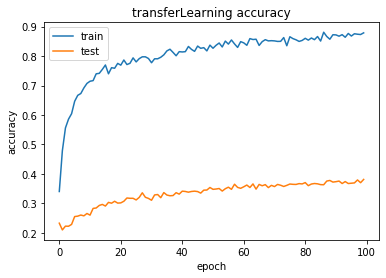

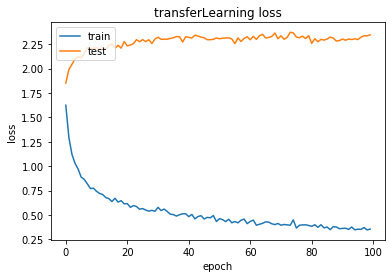

In [0]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
        
#name="SvevaNet"
#plot_history(history, name)
name="transferLearning"
plot_history(history_transfer, name)